In [ ]:
!pip install langgraph langchain_core langchain_community langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain_core
    Found

In [ ]:
from langgraph.graph import StateGraph , START , END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage , HumanMessage
from typing import TypedDict , Literal , Annotated
from pydantic import BaseModel , Field
import operator

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
generator_llm = ChatOpenAI(model_name='gpt-3.5-turbo' )
evaluator_llm = ChatOpenAI(model_name='gpt-4o-mini')
optimizer_llm = ChatOpenAI(model_name='gpt-4o-mini' )

In [ ]:
class Tweetevaluation(BaseModel) :
  evaluation : Literal["approved" , "needs_improvement"] = Field(... , description ="Final evaluation Result" )
  feedback :str = Field(..., description="Feedback for the tweet")

In [ ]:
structure_evaluator_lm  = evaluator_llm.with_structured_output(Tweetevaluation)

In [ ]:
type(structure_evaluator_lm)

langchain_core.runnables.base.RunnableSequence

In [ ]:
class TweetState (TypedDict) :
  topic : str
  tweet : str
  evaluation : Literal["approved" , "needs_improvement"]
  feedback :str
  iteration : int  #  will track how much iteration needs to
  max_iteration : int # to avoid the infinite loop and llm call

  tweet_history : Annotated[list[str] , operator.add]
  feedback_history : Annotated[list[str] ,operator.add ]

In [ ]:
graph = StateGraph(TweetState)

In [ ]:
def generate_post(state:TweetState) :
  Topic = state['topic']

  # prompt for generating the tweet
  messages = [
      SystemMessage(content= "You are a professional and experienced twitter/X influencer."),
      HumanMessage(content=f"""
      your task is to generate the post for the tweeter on the given topic : {Topic}.

      Rules:
    - Do NOT use question-answer format.
    - Max 280 characters.
    - Use sense of humor, irony, professionalism, or ethical references.
    - Think in Professional and exprienced logic, punchlines, or relatable takes.
    - Use simple, day to day english
      """)
  ]
  response = generator_llm.invoke(messages).content

  return {'tweet': response , 'tweet_history' : [response]}


def evaluate_post(state:TweetState) :

  # prompt for evaulating the tweet so we pass the tweet along with the evaluation criteria

  messages = [
    SystemMessage(content="You are an expert X twitter post generator having specializing in professional branding on X (formerly Twitter). You evaluate posts based on clarity, professionalism, engagement potential, and formatting."),
    HumanMessage(content=f"""
  Evaluate the following draft X post:

  Post: "{state['tweet']}"

  Use the criteria below to evaluate the post:

  1. Clarity – Is the message clear, concise, and easy to understand at first glance?
  2. Professionalism – Does it maintain a professional and credible tone suitable for thought leadership or brand communication?
  3. Engagement Potential – Does it encourage interaction, discussion, or sharing?
  4. Relevance – Is it aligned with industry trends, insights, or value-driven content?
  5. Format – Is it structured for readability (under 280 characters, no clutter, well-formatted hashtags or mentions if used)?

  Auto-reject if:
  - It exceeds 280 characters.
  - It is vague, overly casual, or lacks value.
  - It relies on clichés, filler text, or buzzwords without substance.
  - It does not provide any insight, takeaway, or relevance to the intended audience.

  ### Respond ONLY in structured format:
  - evaluation: "approved" or "needs_improvement"
  - feedback: One paragraph explaining the strengths and weaknesses, with a focus on improving clarity, professionalism, and engagement.
  """)
  ]
  response = structure_evaluator_lm.invoke(messages)
  return {'evaluation' : response.evaluation , 'feedback' : response.feedback , 'feedback_history': [response.feedback]}


def optimize_post(state:TweetState) :
  messages = [
    SystemMessage(content="You are an expert social media strategist specializing in creating professional, engaging, and viral-worthy X (Twitter) posts. You refine posts to maximize clarity, impact, and shareability while keeping them authentic to the topic."),
    HumanMessage(content=f"""
    Refine the following post idea into a professional, engaging X (Twitter) post.

    Topic: "{state['topic']}"
    Original Draft:
    {state['tweet']}

    Feedback to incorporate:
    "{state['feedback']}"

    Guidelines:
    - Stay under 280 characters
    - Keep it concise, clear, and professional
    - Use a tone that matches thought leadership + relatability
    - Avoid Q&A style, filler words, or overused clichés
    - Make it scroll-stopping and shareable
    """)
    ]
  respone = generator_llm.invoke(messages).content
  iteration = state['iteration'] + 1
  return {'tweet' : respone , 'iteration' : iteration , 'tweet_history' : [respone]}


def route_eval (state :TweetState ) :
  if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration'] :
    return 'approved'
  else :
    return 'needs_improvement'



In [ ]:
graph.add_node("generate_post", generate_post)
graph.add_node("evaluate_post", evaluate_post)
graph.add_node("optimize_post", optimize_post)

graph.add_edge(START , "generate_post")
graph.add_edge("generate_post" , "evaluate_post")
graph.add_conditional_edges("evaluate_post" , route_eval, {'approved':END , 'needs_improvement':"optimize_post"})
graph.add_edge("optimize_post" , "evaluate_post")

workflow = graph.compile()

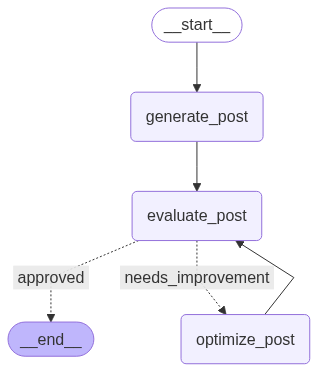

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
initial_state = {
    "topic": "champions League",
    "iteration": 1,
    "max_iteration": 5
}

In [ ]:
result = workflow.invoke(initial_state)

In [ ]:
result

{'topic': 'champions League',
 'tweet': '"Watching the Champions League is like having a rollercoaster of emotions! From the thrill of goals to the agony of missed opportunities, it\'s football drama at its finest. Who will rise to the occasion, and who will fall short? ⚽️🏆 #ChampionsLeague"',
 'evaluation': 'approved',
 'feedback': 'The tweet captures the excitement and emotional rollercoaster of watching the Champions League matches effectively, making it relatable for football fans. It is clear, concise, and adheres to the character limit while retaining a professional tone. The use of engaging questions invites the audience to participate and share their thoughts, enhancing interaction potential. However, to further improve clarity and professionalism, consider elaborating slightly on what makes the Champions League unique or defining specific teams or players to provide more value and insight. Overall, it’s well-structured and formatted, making it a strong post for engaging the au